In [25]:
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from collections import defaultdict
import os
from torch.utils import data
import matplotlib.pyplot as plt

In [26]:
use_cuda = torch.cuda.is_available()

In [27]:
device = torch.device("cuda:0" if use_cuda else "cpu")

In [28]:
device = torch.device("cpu")

In [29]:
OUTPUT_DIR_TRAIN='data/raw/zomato/train.dat'
OUTPUT_DIR_TEST='data/raw/zomato/test.dat'
ROOT_DIR='data/raw/zomato/final_dataset.txt'

In [30]:
movies = []
for line in open(ROOT_DIR):
    movies.append(int(line.split(',')[1]))
print(max(movies))

5137


In [31]:
def get_sparse_mat(filename):
    sparse_dict = defaultdict(list)
    for line in open(filename):
        splitted_line = line.split(',')
        sparse_dict[int(splitted_line[0])].append((int(splitted_line[1]),float(splitted_line[2])))
    
    sparse_mat = []
    sKeys = sorted(sparse_dict)
    for key in sKeys:
        sparse_mat.append(sparse_dict[key])
    return sparse_mat

In [32]:
train_smat = get_sparse_mat(OUTPUT_DIR_TRAIN)

In [33]:
test_smat = get_sparse_mat(OUTPUT_DIR_TEST)

In [34]:
max(test_smat)

[(5136, 5.0),
 (3908, 5.0),
 (4921, 5.0),
 (4665, 5.0),
 (2192, 3.0),
 (1177, 4.0),
 (4781, 5.0),
 (3545, 3.0),
 (1822, 5.0),
 (5058, 5.0)]

In [35]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X_sam = torch.zeros(5138)
        y_sam = torch.zeros(5138)
        for i in range(len(self.X[index])):
            X_sam[self.X[index][i][0]] = self.X[index][i][1]

        for i in range(len(self.y[index])):
            y_sam[self.y[index][i][0]] = self.y[index][i][1]

        return X_sam, y_sam

In [36]:
train_dataset = Dataset(train_smat,train_smat)

In [37]:
test_dataset = Dataset(train_smat, test_smat)

In [38]:
class DAE(nn.Module):
    def __init__(self, movie_size = 5138, hidden_size = 128):
        super(DAE,self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(movie_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, movie_size))
    
    def forward(self, x):
        return self.model(x)

In [39]:
net = DAE()

In [40]:
def masked_loss(preds, labels):
    mask = torch.where((labels!=0), torch.Tensor([1]),torch.Tensor([0]))
    masked_preds = preds*mask
    loss = torch.sum((masked_preds - labels)**2)/(torch.sum(mask))
    return loss

In [41]:
criterion = masked_loss

In [42]:
opti = optim.Adam(net.parameters(), lr=1e-2)

In [43]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 10
training_generator = data.DataLoader(train_dataset, **params)
validation_generator = data.DataLoader(test_dataset, **params)

In [44]:
training_generator

In [45]:
net = net.to(device)

In [46]:
train_losses = []
val_losses = []

In [47]:
for epoch in range(max_epochs):
    running_loss = 0
    cnt = 0
    for batch_X, batch_y in training_generator:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        opti.zero_grad()
        batch_preds = net(batch_X)
        loss = criterion(batch_preds, batch_y)
        loss.backward()
        opti.step()
        running_loss += loss.item()
        cnt += 1
        
    print("Epoch {}: Training Loss {}".format(epoch+1, running_loss/cnt))
    train_losses.append(running_loss/cnt)
    
    running_loss = 0
    cnt = 0
    with torch.set_grad_enabled(False):
        for batch_X, batch_y in validation_generator:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            batch_preds = net(batch_X)
            loss = criterion(batch_preds, batch_y)
            running_loss += loss.item()
            cnt += 1
    print("Epoch {}: Validation Loss {}".format(epoch+1, running_loss/cnt))
    
    val_losses.append(running_loss/cnt)

Epoch 1: Training Loss 7.006088090794427
Epoch 1: Validation Loss 3.6529147156647275
Epoch 2: Training Loss 2.168512067624501
Epoch 2: Validation Loss 1.1676863602229528
Epoch 3: Training Loss 0.8579511387007577
Epoch 3: Validation Loss 0.7499207854270935
Epoch 4: Training Loss 0.6380847745708057
Epoch 4: Validation Loss 0.7330157597150121
Epoch 5: Training Loss 0.5978099043880191
Epoch 5: Validation Loss 0.7044403084686824
Epoch 6: Training Loss 0.5672301197690623
Epoch 6: Validation Loss 0.7023302827562604
Epoch 7: Training Loss 0.5427031442523003
Epoch 7: Validation Loss 0.6985592203480857
Epoch 8: Training Loss 0.5278019633676324
Epoch 8: Validation Loss 0.7018454862492425
Epoch 9: Training Loss 0.5136057947363172
Epoch 9: Validation Loss 0.702987260052136
Epoch 10: Training Loss 0.4951008957411562
Epoch 10: Validation Loss 0.7106323391199112


Text(0.5,0,'Epochs')

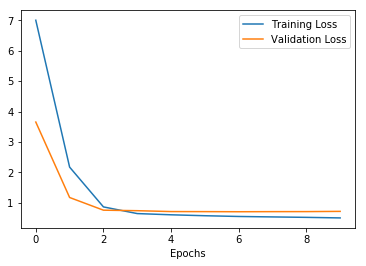

In [48]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')

In [49]:
val_losses[-1]

0.7106323391199112

In [50]:
x, y = test_dataset.__getitem__(3)

In [51]:
pred = net(x)

In [52]:
pred[y!=0]

tensor([3.8338, 3.5581, 3.7072, 4.1076, 3.6692, 3.8522, 4.1767, 3.8528, 4.0979,
        4.3406], grad_fn=<TakeBackward>)

In [53]:
y[y!=0]

tensor([5.0000, 4.0000, 5.0000, 4.5000, 3.5000, 3.5000, 3.5000, 4.5000, 4.5000,
        5.0000])